<a href="https://colab.research.google.com/github/cottascience/crosstalk-q1-2025/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis (EDA)

Today we'll be investigating the HitGen DEL library for the protein WDR91.

HitGen has screened a large set of compounds which are proprietary. Lucky for us they have shared fingerprints of these compounds, and we can use these to search within a catalogue of non-proprietary compounds to prioritize what to test as a potential binder of WDR91.

We'll work through the following goals:
1. Investigate the data
1. Learn about a published approach
1. Start planning your approach



# Getting started

In order to use HitGen data, we have to agree to the terms of service. Click through downloading the WDR91 dataset [here](https://aircheck.ai/datasets) to agree to these. (you don't have to download the whole dataset to agree to ToS)

⚠️**Compounds fingerprints cannot be reversed-engineered to obtain SMILES**



The [aircheck readme](https://aircheck.ai/readme) provides useful details about the DEL screening.


✏️ Make note of the following:
* How is a positive defined in a DEL screen?
* What is the class balance of all DEL datasets on aircheck?
* Look at the data dictionary. What columns might be useful to investigate?




# Our protein of interest: WDR91

WDR91 is a WD40 repeat-containing protein. Proteins in this family act as scaffolds for other proteins to stick to when forming multiprotein complexes WDR domain-containing proteins comprise one of the largest protein families in humans and are involved in a diverse array of cellular networks and diseases.

WDR91 plays a critical role in regulating early-to-late endosomal maturation and trafficking, processes essential for cellular functions such as nutrient uptake, signal transduction, and membrane protein recycling [1][2]

[1]: Schapira, Matthieu, et al. "WD40 repeat domain proteins: a novel target class?." Nature reviews Drug discovery 16.11 (2017): 773-786. ([link](https://doi.org/10.1038/nrd.2017.179))

[2]: Stirnimann, Christian U., et al. "WD40 proteins propel cellular networks." Trends in biochemical sciences 35.10 (2010): 565-574. ([link](https://doi.org/10.1016/j.tibs.2010.04.003))



✏️ Try the following:
* look it up on uniprot https://www.uniprot.org/uniprotkb/A4D1P6/entry
* where is it located in the cell? what does it do?
* what disease is disfunction of this protein associated with?


# Molecular fingerprints

Molecular fingerprints are computational representations of molecules that encode chemical features of a molecule in the form of a binary digit (1 if present, 0 if not). There are multiple ways of designing fingerprints.


## Molecular ACCess System (MACCS) fingerprints

Also termed MACCS structural keys, they consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key. The individual keys were empirically defined by medicinal chemists and are simple to use and interpret [1]

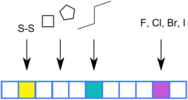

## Morgan fingerprints

They are based on the Morgan algorithm. The bits correspond to the circular environments of each atom in a molecule. The number of neighboring bonds and atoms to consider is set by the radius. Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. Therefore, the Morgan fingerprint is not limited to a certain number of bits.

## Extended connectivity fingerprints (ECFP)

 are also commonly used fingerprints that are derived using a variant of the Morgan algorithm, see J. Chem. Inf. Model. (2010), 50,742-754 for further information.


[1]: [Talktorial 004 Volkamer](https://projects.volkamerlab.org/teachopencadd/talktorials/T004_compound_similarity.html)

[2]: [Chembook ECFP Blogpost](https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html)

## Generate a molecular fingerprint with RDKit from a SMILES string

In this section, we will briefly demonstrate how molecular fingerprints can easily be obtained using the `rdkit` package.


In [ ]:
!pip install rdkit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 32.9 MB/s eta 0:00:00


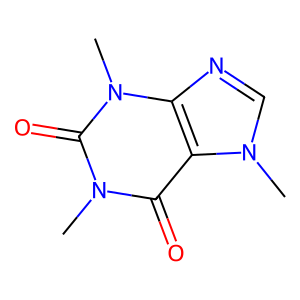

In [18]:
# the smile for caffiene - try replacing with your favourite molecule
smiles = "Cn1cnc2c1c(=O)n(C)c(=O)n2C"
mol = Chem.MolFromSmiles(smiles)

Draw.MolToImage(mol)

In [ ]:
# initialize Morgan Fingerprint generator
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

# get the fingerprint of our RDKit mol object
fp = mfpgen.GetFingerprint(mol)

ecfp4 = np.array(fp)

print(ecfp4.shape)
print(ecfp4)

(2048,)
[0 0 0 ... 0 0 0]


# Load the data

We've prepared a training dataset for you which will download when you run the next cell. This is a large file, so we won't load the whole thing into memory all at once.




In [14]:
# Download the file from google drive
import gdown
import os

url = "https://drive.google.com/file/d/11S5p0QgP1X9rOFiIjNSLydLenJwm7hle/view?usp=sharing"
train_file = 'crosstalk_train.parquet'
if not os.path.exists(train_file):
    gdown.download(url=url output=train_file, quiet=False)

We'll also load some extra packages to use in our EDA

In [17]:
# package to efficiently read in data from parquet file
from pyarrow.parquet import ParquetFile
import pyarrow as pa

# packages to help us with data manipulation in tables
import pandas as pd
import numpy as np

# packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# package for making umaps
!pip install umap-learn
import umap


In [16]:
# Read data from parquet file
pf = ParquetFile(train_file)

# load all columns of the first 10 rows
first_ten_rows = next(pf.iter_batches(batch_size = 10))
train_data = pa.Table.from_batches([first_ten_rows]).to_pandas()

In [19]:
train_data.head()

ID           DEL_ID  Label  RawCount Target  \
0  22010204180211  L22-102-418-211      0         0  WDR91   
1  30023100530730   L30-231-53-730      0         0  WDR91   
2  30004703160748   L30-47-316-748      0         0  WDR91   
3  30004200250347    L30-42-25-347      0         0  WDR91   
4  22002800290407    L22-28-29-407      0         0  WDR91   

                                               ECFP4  \
0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
4  0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...   

                                               ECFP6  \
0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
4  0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...   

                                               FCFP4  \
0  12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
1  12,2,6,0,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  10,1,2,0,16,0,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...   
3  12,2,3,0,14,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...   
4  8,2,3,0,17,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   

                                               FCFP6  \
0  12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
1  12,2,6,0,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  10,1,2,0,16,0,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...   
3  12,2,3,0,14,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...   
4  8,2,3,0,17,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   

                                               MACCS  \
0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
4  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...   

                                                 RDK  \
0  1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,1,...   
1  1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,...   
2  1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,0,0,0,...   
3  1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,...   
4  1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,0,...   

                                              AVALON  \
0  0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,15,0,3,0,0,0,0,0...   
1  0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,1,2...   
2  1,0,0,1,4,0,1,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0...   
3  0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,11,0,0,0,0,0,0,0...   
4  1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,...   

                                            ATOMPAIR  \
0  1,0,0,0,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...   
1  0,0,0,0,2,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3,...   
3  0,1,0,1,3,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...   
4  0,1,0,0,4,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,0,0,...   

                                              TOPTOR   MW  ALOGP  
0  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  493    3.4  
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  494    3.4  
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  494    3.4  
3  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  494    3.4  
4  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  495    3.4

Take some time to explore what the different columns mean:


| Field Name   | Data Type | Mode     | Description                                                                 |
|--------------|-----------|----------|-----------------------------------------------------------------------------|
| ID           | Long      | Required | Unique computed ID from DEL_ID concatenating DEL Library ID and Building Block IDs. |
| DEL_ID       | String    | Required | Unique ID of full enumerated DNA-Encoded Library (DEL) compound.            |
| Label        | Integer   | Required | Binary classification label for observed enrichment (0 not enriched, 1 enriched). |
| RawCount     | Integer   | Nullable | The sequence count (enrichment) for the specific target.                    |
| TARGET_ID    | String    | Required | Unique ID of the target.                                                   |
| ECFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 2 and 2048 bits. |
| ECFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 3 and 2048 bits. |
| FCFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 2 and 2048 bits. |
| FCFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 3 and 2048 bits. |
| MACCS        | Bytes     | Nullable | FP generated using the Molecular Access System (MACCS).                     |
| RDK          | Bytes     | Nullable | FP generated using the RDKit fingerprint.                                  |
| AVALON       | Bytes     | Nullable | FP generated using the Avalon fingerprint.                                 |
| ATOMPAIR     | Bytes     | Nullable | FP generated using the Atom Pair fingerprint.                               |
| TOPTOR       | Bytes     | Nullable | FP generated using the Topological Torsion fingerprint.                     |
| MW           | Float     | Nullable | Molecular weight of the enumerated DEL rounded to its integer value.        |
| ALOGP        | Float     | Nullable | Calculated LogP of the enumerated DEL rounded to one decimal. Synonymous with ClogP. |



✏️ Let's check it out:
* How many compounds are in this screen?
* How many of these are enriched?


In [88]:
# load all rows of select columns
columns_to_load = ['Label', 'RawCount', 'ECFP4', 'MW', 'ALOGP']
train_data = pd.read_parquet(train_file, columns=columns_to_load)

In [89]:
train_data.shape

(375595, 5)

In [90]:
train_data['Label'].sum()

28778

# Investigate molecular properties

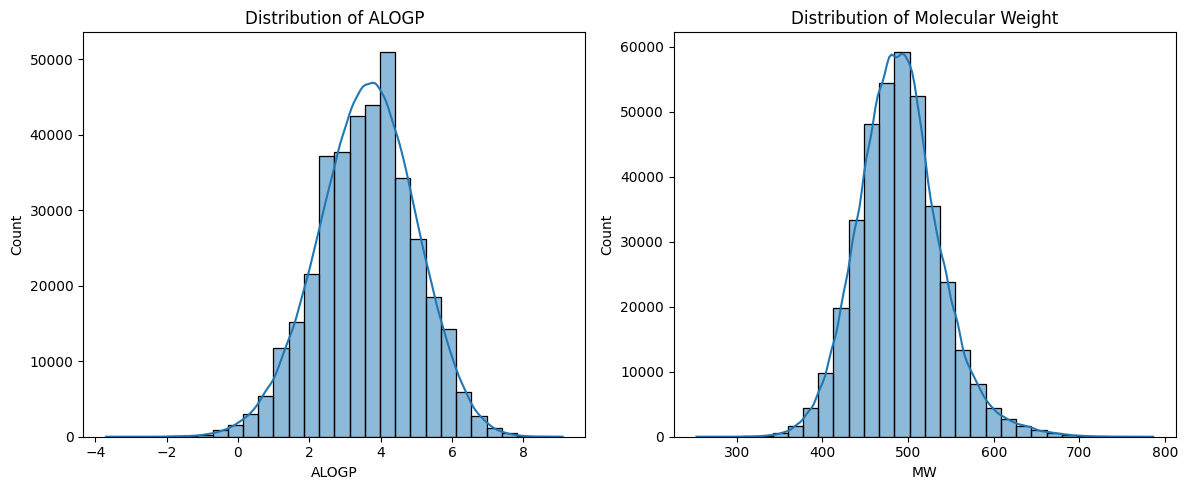

In [98]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ALOGP histogram
sns.histplot(data=train_data, x="ALOGP", kde=True, bins=30, ax=axes[0])
axes[0].set_title("Distribution of ALOGP")

# Plot MW histogram
sns.histplot(data=train_data, x="MW", kde=True, bins=30, ax=axes[1])
axes[1].set_title("Distribution of Molecular Weight")

# Adjust layout
plt.tight_layout()
plt.show()

# Labels exploration

Enrichment has been binarized to 0 (not enriched) and 1 (enriched), but we can also look at the raw counts. Note: It is possible for inactive compounds to have non-zero raw count.

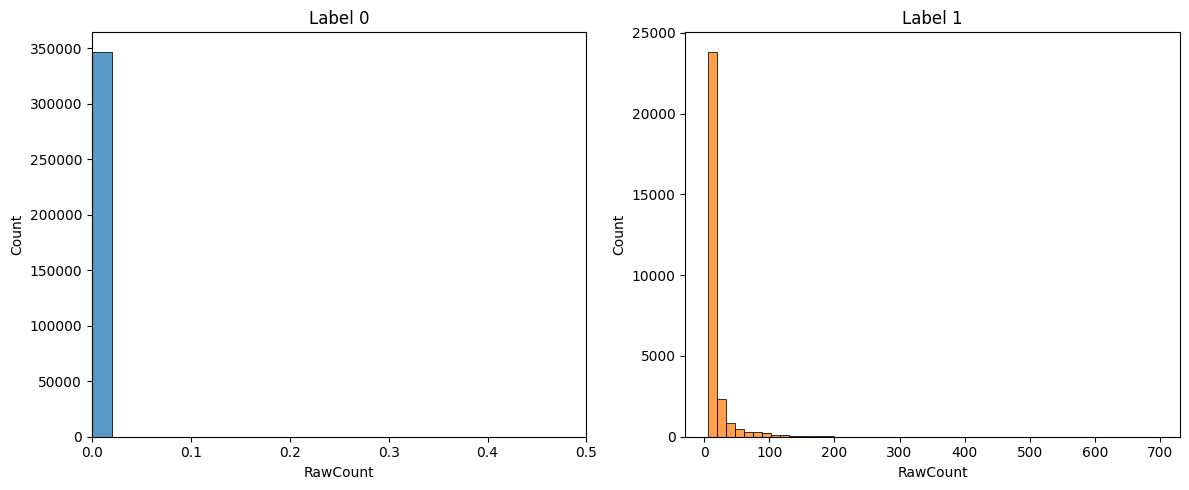

In [127]:
# Plot raw counts and label of enrichment
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

# Label 0 plot
sns.histplot(data=train_data[train_data['Label']==0], x="RawCount", bins=50, color='#1f77b4', ax=ax1)
ax1.set_xlim(0, 0.5)
ax1.set_title('Label 0')

# Label 1 plot
sns.histplot(data=train_data[train_data['Label']==1], x="RawCount", bins=50, color='#ff7f0e', ax=ax2)
ax2.set_title('Label 1')

plt.tight_layout()
plt.show()

# Class imbalance

This is a very unbalanced data set, a common thing in drug discovery

In [128]:
# Let's look at how many DEL hits there are
# Calculate the ratio of labels
label_counts = train_data['Label'].value_counts(normalize=True)

# Print the ratio of labels
print(label_counts)

Label
0    0.92338
1    0.07662
Name: proportion, dtype: float64


# Have a look 👀

Let's have a look at what our training set looks like using UMAP on the ECFP4 fingerprints.

✏️ Try this
* Roughly how many distinct groups of chemicals might there be?
* Are the enriched (DEL label "1") compounds all similar to each other?
* Are there clusters with higher molecular weight than others?
* Are there clusters with higher ALOGP than others?
* Are these answers the same if we change the fingerprint type?

In [51]:
# convert the first 5k ECFP4 strings into lists
X = np.array([list(map(int, s.split(','))) for s in train_data["ECFP4"][:5000]])

In [52]:
# prepare umap dimensionality reduction
umap = umap.UMAP(
        n_components=2,
        n_neighbors=20,
        min_dist=0.1,
        metric="jaccard",
        random_state=42
    )

# fit the umap
embedding = umap.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

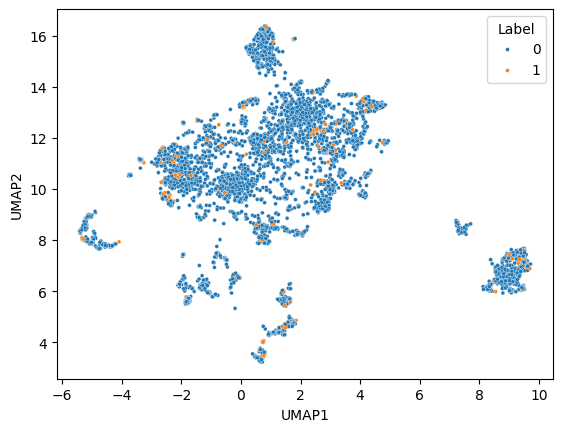

In [66]:
# format as table
embedding = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Create a scatter plot
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['Label'][:5000], s=8)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

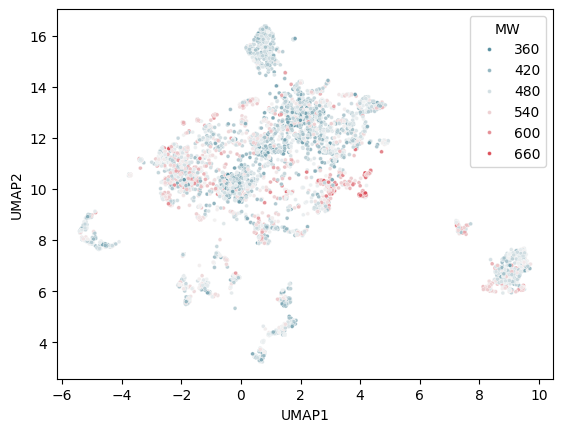

In [67]:
# recolour by molecular weight
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['MW'][:5000], s=8,
                palette = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True))

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

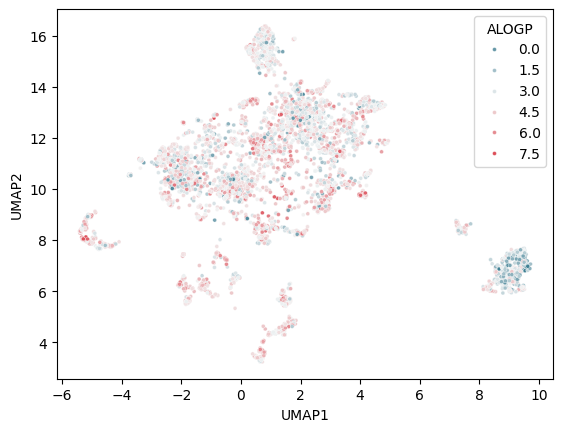

In [68]:
# recolour by ALOGP
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['ALOGP'][:5000], s=8,
                palette = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True))

# Build a linear model

Let's build a simple logistic regression model using `sklearn`.

Input: ECFP4 Fingerprints

Output: Label

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [134]:
# First let's convert the ECFP4 strings into lists
X = np.array([list(map(int, s.split(','))) for s in train_data["ECFP4"][:100000]])

In [135]:
y = train_data['Label'][:100000].values  # Binary labels

In [136]:
# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
# Train a simple logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.95


# The importance of metrics

The accuracy metric we used above does not take into account class imbalance! A dummy prediction which guesses 0 for everything will also get us a high accuracy...

In [142]:
dummy_pred = np.zeros(y_test.shape)

# Evaluate model performance
accuracy = accuracy_score(y_test, dummy_pred)
print(f'Dummy Accuracy: {accuracy:.2f}')

Dummy Accuracy: 0.92


Other metrics are more useful in imbalanced settings. Specifically for our drug screening, we may be more interested in precision (ie. all our predictions are positive) than recall (ie. we predicted ALL the positives)


![Precision vs Recall](media/precision_vs_recall.png)

In [145]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Compute recall score
recall = recall_score(y_test, y_pred)
print(f'Model Recall: {recall:.2f}')

# Compute precision score
precision = precision_score(y_test, y_pred)
print(f'Model Precision: {precision:.2f}')

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f'Model F1: {f1:.2f}')


Model Recall: 0.48
Dummy Recall: 0.00
Model Precision: 0.72
Dummy Precision: 0.00
Model F1: 0.58
Dummy F1: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Whereas the dummy predictor will not be successful in these aspects

In [146]:
print(f'Dummy Recall: {recall_score(y_test, dummy_pred):.2f}')
print(f'Dummy Precision: {precision_score(y_test, dummy_pred):.2f}')
print(f'Dummy F1: {f1_score(y_test, dummy_pred):.2f}')

Dummy Recall: 0.00
Dummy Precision: 0.00
Dummy F1: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Your turn

Start thinking about your model. What kinds of data and modelling challenges do you forsee?

* How can we improve generalization to unseen data?
* How can we mitigate class balance challenges?
* Is this dataset representative of the real world? Why or why not?

What other metrics can we use?  
* Keep in mind we need to rank compounds, not just predict binding.